# Image Classification with Convolutional Neural Networks

## Imports and check device

In [1]:
import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations

import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import numpy as np #for basic array operations
#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load Data - CIFAR10

Let's use a simple built-in dataset, that is available and easy to download. The CIFAR-10 dataset (Canadian Institute for Advanced Research, 10 classes) is a subset of the Tiny Images dataset and consists of 60000 32x32 color images. Good collection of datasets and methods by Meta, which is worth checking: (https://paperswithcode.com/dataset/cifar-10).

Let's discuss how dataloader works!

In [2]:
#how many samples per batch to load
batch_size = 16


#transform data to tensor and normalize with mean=0.5 and standard deviation=0.5 for each channel
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
#     transforms.RandomPerspective(distortion_scale=0.2),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# load training set and apply transform
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# validation set is not available here

# load test set and apply transform (transformations are usually not applied on the test set for comparison reason)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Since there is no validation set for the data set, we will use the test set for a better presentation and can be tested on external images as needed.
validloader=testloader
(testsize,_,_,_)=testset.data.shape
validationsize=testsize

#CIFAR10 has the following 10 classes:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print("Training set shape (Number of Images, Height, Width, Number of channels):\n",trainset.data.shape)
print("Test set shape (Number of Images, Height, Width, Number of channels):\n", testset.data.shape)
print("Available classes: ", classes)

Files already downloaded and verified
Files already downloaded and verified
Training set shape (Number of Images, Height, Width, Number of channels):
 (50000, 32, 32, 3)
Test set shape (Number of Images, Height, Width, Number of channels):
 (10000, 32, 32, 3)
Available classes:  ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


### Plot images

 ship  frog   dog   car plane  frog  ship   car   cat  deer horse  bird horse  frog   dog   cat


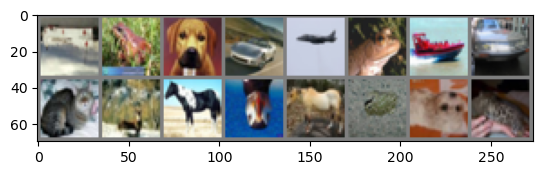

In [3]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     #because images were normalized when loaded, for visualization purposes we denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #reorder the channels 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels =next(dataiter)    # or in previous version: dataiter.next()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))

## 2. Create and Train a Convolutional Neural Network (CNN)

Convolution and pooling layers are fundamental operations for building CNN models. There are a number of parameters and if their definitions are not clear, it could lead to great confusion.
- Parameters for convolution (pooling) layers
  - **stride:** how many "steps" that the filter makes for each advance
  - **kernel size**: how large is the kernel (filter) is
  - **number of filters (channels):** designates the "depth" of the data. Most image inputs have three filters (RGB)
  - **padding:** how to pad the input sample with zero in the border
- How to calculate output size of convolution/pooling operation
  <br> 
*(W - F + 2P)/S + 1* <br>
  - *W*: input size
  - *F*: kernel size
  - *P*: padding 
  - *S*: stride

Convolution 2D (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

The 2D convolution use 'out_channels' number kernel. This kernel tensor “slides” (naive implementation) over the 2D input data, performing an elementwise multiplication with the overlaped input and then summing up the results into a single output.

nn.Conv2d()
- in_channels (int) – Number of channels in the input image
- out_channels (int) – Number of channels produced by the convolution
- kernel_size (int or tuple) – Size of the convolving kernel
- stride (int or tuple, optional) – Stride of the convolution. Default: 1
- padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0
- padding_mode (str, optional) – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'
- dilation (int or tuple, optional) – Spacing between kernel elements. Default: 1
- groups (int, optional) – Number of blocked connections from input channels to output channels. Default: 1
- bias (bool, optional) – If True, adds a learnable bias to the output. Default: True

<img src="https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif" style="max-width:400px;">

Max Pooling 2D (https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)

Convolution is not responsible for data compression, pooling layers are used to reduce the size of neural networks and speed up the process, by highlighting the most important parts.

nn.MaxPool2d()
- kernel_size (int or tuple) – Size of the convolving kernel
- stride (int or tuple, optional) – Stride of the convolution. Default: 1
- padding (int, tuple or str, optional) – Padding added to all four sides of the input. Default: 0

![alt text](https://user-images.githubusercontent.com/22738317/34081046-c3a97518-e347-11e7-98fe-929f602ee857.png)

Let's test the pooling and convolutional operations on some examples (check input type requirements too)

In [4]:
t = torch.tensor([[[0,0,1],
                   [1,2,3],
                   [7,5,3],
                   [5,3,6]],
                  
                  [[9,11,10],
                   [10,11,12],
                   [31,55,32],
                   [17,29,32]]], dtype=torch.float32, requires_grad=True)

print(t.shape)
print(t)

# t2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
# t2 = nn.AvgPool2d(kernel_size=2, stride=1, padding=1)
t2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=5, stride=1, padding='same')

print()
print(t2(t).shape)
print(t2(t))

torch.Size([2, 4, 3])
tensor([[[ 0.,  0.,  1.],
         [ 1.,  2.,  3.],
         [ 7.,  5.,  3.],
         [ 5.,  3.,  6.]],

        [[ 9., 11., 10.],
         [10., 11., 12.],
         [31., 55., 32.],
         [17., 29., 32.]]], requires_grad=True)

torch.Size([4, 4, 3])
tensor([[[ -9.3493, -16.3500, -12.8761],
         [-21.0720, -18.9977,  -9.9412],
         [-22.0710, -14.6708,  -8.5408],
         [-20.7309, -10.7425,  -7.1272]],

        [[ 13.1645,   7.9807,   2.9624],
         [  9.1277,   7.9359,   3.8449],
         [ -1.1959,  -4.3044,   2.0469],
         [ -9.0561,  -1.4082,   3.2948]],

        [[  0.9541,   0.7195,  -0.0253],
         [ -1.5074,  -4.8806,  -4.6497],
         [  4.9009,   2.2970,   5.6695],
         [  6.5708,   7.7959,   7.8343]],

        [[ -8.4559,  -4.3747,   6.2813],
         [ -9.5837,  -6.4935,   5.2458],
         [  6.3262,   0.0383,  -1.8144],
         [  5.4622,  -3.6672,  -7.5331]]], grad_fn=<SqueezeBackward1>)


## Model

Convolutional Neural Network (two convolutional blocks + fully connected layers). The fully connected layers are optional and nowadays rarely used, but help with the flexible output size. Try different models and check how they influence accuracy and execution times.

In [5]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        #First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding='same'),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding='same'),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding='same'),
            #padding: 'zeros', 'reflect', 'replicate' or 'circular'
            #padding: 'same', 'valid'
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Second convolutional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=5, stride=1, padding='same'),
            nn.ReLU(), #nn.Sigmoid()
            nn.MaxPool2d(kernel_size=2, stride=2))
        #Fully connected layers
        self.layer3 = nn.Sequential(
            nn.Linear(1024, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out) 
        out = torch.flatten(out, 1) # flatten all dimensions except batch
        out = self.layer3(out)
        return out

How can we decide the number of layers, kernel, ...?  If we understand how the network works and understand the task and the data we can initialize a network. If that problem is common, then we can use similar pre-trained models to start. Otherwise, it is recommended to do some tests and based on the results and expert knowledge do the modifications or use a hyperparameter search. Let's discuss some simple rules together.

### Let's create the neural network, set up the device and get a simple vizualisation

In [6]:
convnet = ConvNet(10).to(device)
convnet

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1024, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [7]:
# !pip install torchsummary 
from torchsummary import summary

summary(convnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 64, 32, 32]          51,264
            Conv2d-3           [-1, 64, 32, 32]         102,464
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6           [-1, 16, 16, 16]          25,616
              ReLU-7           [-1, 16, 16, 16]               0
         MaxPool2d-8             [-1, 16, 8, 8]               0
            Linear-9                  [-1, 120]         123,000
             ReLU-10                  [-1, 120]               0
           Linear-11                   [-1, 84]          10,164
             ReLU-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 315,790
Trainable params:

## Visualisation with Tensorboard

Tensorboard has nice visualization features

- SummaryWriter('runs/CIFAR10') - specifying the log directory, default is "runs" 
- read one or more batches with iter() and next()
- visualize the batch in a grid view 
- writer.add_image('CIFAR10_batch', img_grid) - show img_grid in Tensorboard as 'CIFAR10_batch'

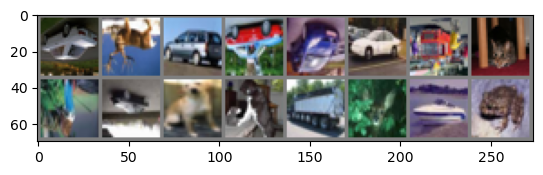

In [8]:
from torch.utils.tensorboard import SummaryWriter
# initialize the summary 
writer = SummaryWriter('runs/CIFAR10')

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
imshow(img_grid)

# write to tensorboard
writer.add_image('CIFAR10_batch', img_grid)


In [24]:
# %load_ext tensorboard

%reload_ext tensorboard

# Set up a logs directory, so Tensorboard knows where to look for files.
%tensorboard --logdir="runs" --host localhost  # visit http://localhost:6006 for a larger view

Reusing TensorBoard on port 6006 (pid 12196), started 8:28:41 ago. (Use '!kill 12196' to kill it.)

In [10]:
writer.add_graph(convnet.cpu(), images.cpu()) # refresh the tensorboard to see the changes
writer.close()

In [11]:
convnet.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=1024, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

## Optimizers 
There are some pre-built optimizers in PyTorch (https://pytorch.org/docs/stable/optim.html), they are sufficient in most cases, especially if their parameters are well set. The two most well-known are ADAM and SGD, both of which originate from Gradient Descent, which we implemented earlier.

* **S**tochastic **G**radient **D**escent  - https://pytorch.org/docs/stable/generated/torch.optim.SGD.html
* **ADA**ptive **M**oment optimizer - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
* A good general overview - https://www.ruder.io/optimizing-gradient-descent/


In [12]:
optimizer = optim.SGD(convnet.parameters(), lr=0.01, momentum=0.8)
#optimizer = optim.Adam(convnet.parameters(), lr=0.1,betas=[0.95, 0.99])

## Loss function 

In [13]:
criterion = nn.CrossEntropyLoss()

## Train

- load the batch - inputs, labels = data[0].to(device), data[1].to(device) 
- zero the parameter gradients - optimizer.zero_grad() 
- forward  function - outputs = convnet(inputs) 
- calculate the loss - loss = criterion(outputs, labels) 
- calculate the gradient - loss.backward() 
- update the parameters - optimizer.step() - update the parameters

validation:
- "with torch.no_grad" is recommended for comparison it keeps the "training layers"
- "model.eval() remove every "training layers"
- calculate the loss - loss = criterion(outputs, labels) 


In [14]:
NUM_EPOCHS = 3
total_loss_h=[]
total_vloss_h=[]
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    print(f'Epoch {epoch}:')
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device) 

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = convnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # updating the weights of the network

        # print statistics
        total_loss_h.append(np.array(loss.cpu().detach()))
        
        if i % 200 == 0:  
            with torch.no_grad():
                # convnet.eval()
                vloss=0
                for iv, datav in enumerate(validloader, 0):
                    inputs, labels = datav[0].to(device), datav[1].to(device) 
                    outputs = convnet(inputs)
                    vloss = np.array(criterion(outputs, labels).cpu().detach())
                print(f'Iteration {i}, loss = {(loss):.3f}, vloss = {(vloss):.3f}')
        total_vloss_h.append(vloss)

print('Finished Training')

Epoch 0:
Iteration 0, loss = 2.296, vloss = 2.296
Iteration 200, loss = 2.298, vloss = 2.268
Iteration 400, loss = 2.057, vloss = 2.044
Iteration 600, loss = 2.142, vloss = 1.882
Iteration 800, loss = 1.811, vloss = 1.840
Iteration 1000, loss = 1.644, vloss = 1.638
Iteration 1200, loss = 1.859, vloss = 1.341
Iteration 1400, loss = 1.771, vloss = 1.379
Iteration 1600, loss = 2.487, vloss = 1.596
Iteration 1800, loss = 1.776, vloss = 1.767
Iteration 2000, loss = 1.536, vloss = 1.565
Iteration 2200, loss = 1.349, vloss = 1.310
Iteration 2400, loss = 1.921, vloss = 1.702
Iteration 2600, loss = 1.279, vloss = 1.264
Iteration 2800, loss = 1.643, vloss = 1.350
Iteration 3000, loss = 1.818, vloss = 1.390
Epoch 1:
Iteration 0, loss = 1.431, vloss = 1.494
Iteration 200, loss = 1.493, vloss = 1.569
Iteration 400, loss = 2.522, vloss = 1.506
Iteration 600, loss = 0.899, vloss = 1.209
Iteration 800, loss = 1.641, vloss = 1.586
Iteration 1000, loss = 1.012, vloss = 1.437
Iteration 1200, loss = 1.405

(0.0, 10.0)

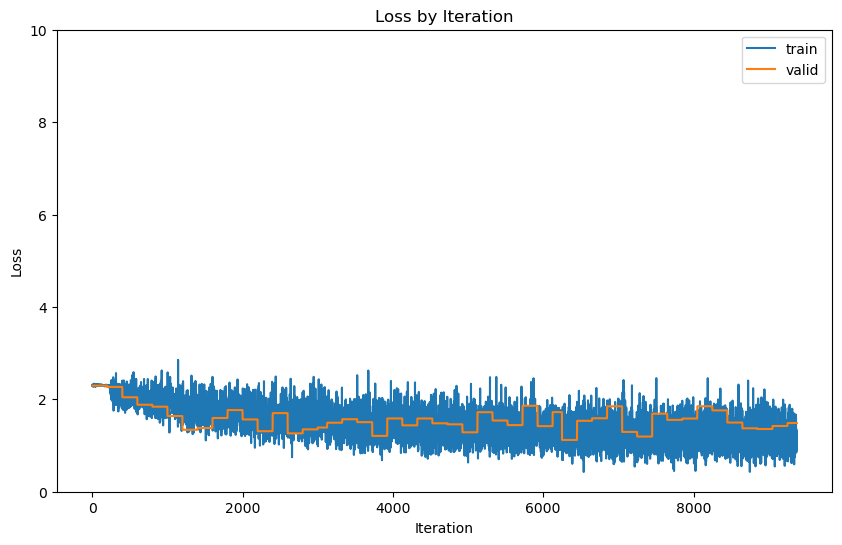

In [15]:
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss by Iteration')

plt.plot(total_loss_h)
plt.plot(total_vloss_h)
plt.legend(['train', 'valid'])
plt.ylim((0,10))

### Save trained model

In [16]:
PATH = './cifar_net.pth'
torch.save(convnet.state_dict(), PATH)

### Load the model

In [17]:
PATH = './cifar_net.pth'
convnet = ConvNet().to(device)
convnet.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Test

Testing - the test data set is used, it does not participate in training in any way, and the goal is independent testing and comparison

###  Predict some images

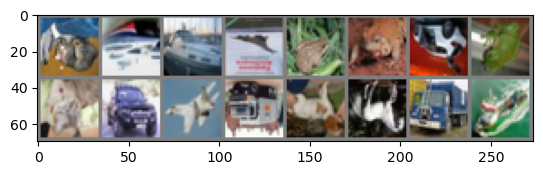

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship
Predicted:  horse   car   car   car  frog   cat   car  frog   cat   car   cat truck   dog truck truck  frog


In [18]:
dataiter = iter(testloader)
data = next(dataiter)
images = data[0]
labels = data[1]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

images, labels = data[0].to(device), data[1].to(device)
convnet.eval()
outputs = convnet(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

## Accuracy on Test set

In [19]:
correct = 0
total = 0
labels_total=[]
prediction_total=[]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = convnet(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu()
        labels_total=np.append(labels_total,labels.numpy(), axis=0)
        prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


### Accuracy on test set per class

In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #inputs, labels = data[0].to(device), data[1].to(device) #set for GPU if available
        outputs = convnet(images.to(device))
        _, predictions = torch.max(outputs, 1)
        predicted=predicted.cpu()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 55.6 %
Accuracy for class car   is: 78.9 %
Accuracy for class bird  is: 48.2 %
Accuracy for class cat   is: 34.7 %
Accuracy for class deer  is: 51.8 %
Accuracy for class dog   is: 51.3 %
Accuracy for class frog  is: 60.2 %
Accuracy for class horse is: 68.0 %
Accuracy for class ship  is: 55.3 %
Accuracy for class truck is: 61.2 %


## Confusion matrix or Heatmap

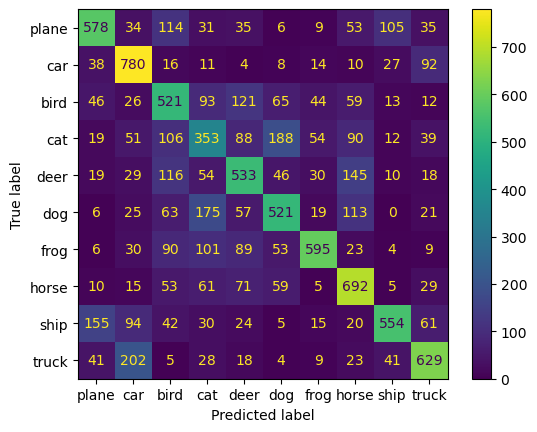

In [21]:
# !conda install scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(labels_total, prediction_total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

<Axes: >

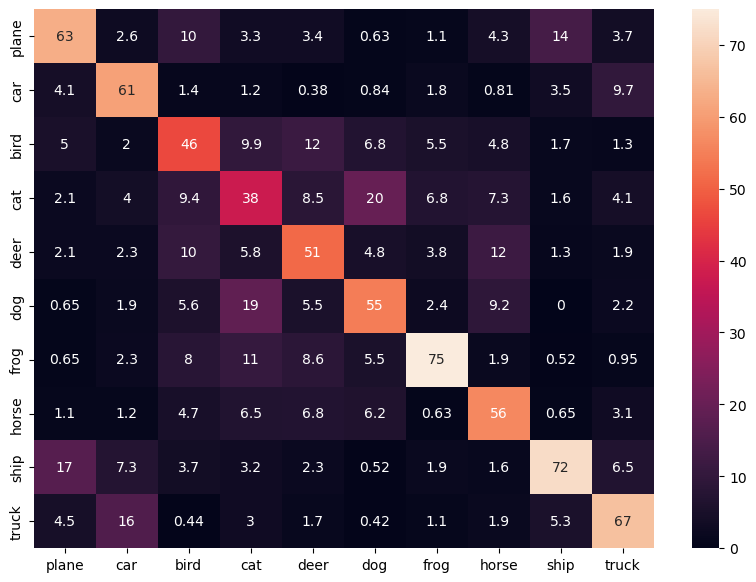

In [22]:
# conda install pandas
# conda install seaborn
import seaborn as sn
import pandas as pd
cm=cm/np.sum(cm,axis=0)*100 # axis=0 rows of a data 
df_cm = pd.DataFrame(cm, index =  classes, columns =  classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# !pip install pretty-confusion-matrix # Python <3.11

# import numpy as np
# import pandas as pd
# from pretty_confusion_matrix import pp_matrix
# df_cm = pd.DataFrame(cm, index =  classes, columns =  classes)
# plt.figure(figsize = (10,7))
# cmap = 'gist_ncar' #'seismic' color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# pp_matrix(df_cm, cmap=cmap)

<div style="text-align: right">Created by Szilárd Kovács</div>